In [1]:
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime
import numpy as np
from itertools import product
import math
import pyproj
import re
import pyspark

In [2]:
resolution = 2000  #grid resolution in meters

In [3]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-25 09:16:06.008609] Starting...


In [4]:
lp("Creating spark context")
conf = pyspark.SparkConf().setAppName("ProcessLidar").setMaster("spark://G-ChaosStation:7077")
sc = pyspark.SparkContext(conf=conf)

[2025-03-25 09:16:06.012987] Creating spark context


25/03/25 10:16:07 WARN Utils: Your hostname, G-ChaosStation resolves to a loopback address: 127.0.1.1; using 192.168.12.163 instead (on interface eno1)
25/03/25 10:16:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/25 10:16:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
fullDataPath = os.path.realpath(dataPath) + os.sep
lp(f"Path:  {dataPath}\t\tFullPath:{fullDataPath}")

[2025-03-25 09:16:09.086465] Path:  ./datasets/		FullPath:/home/g/Dev/NewOrleansElevation/datasets/


In [6]:
testLasFileName = os.listdir(f"{dataPath}laz")[5]
lp(f"Opening {testLasFileName} to get crs and more")
testLas = laspy.read(f"{dataPath}laz{os.sep}{testLasFileName}")

[2025-03-25 09:16:09.094437] Opening USGS_LPC_LA_2021GreaterNewOrleans_C22_w0819n3342.laz to get crs and more


In [7]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

<Axes: >

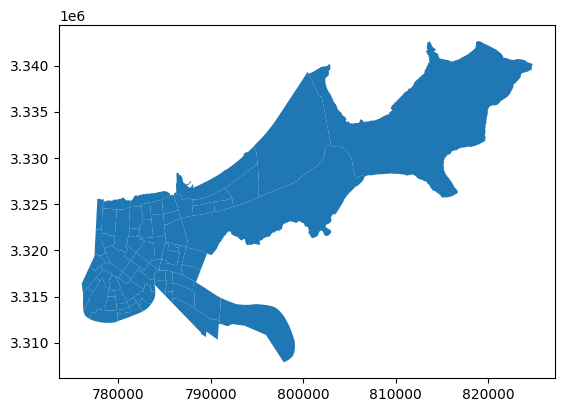

In [8]:
neighborhoodDf.plot()

In [9]:
bounds = [int(b) for b in neighborhoodDf.total_bounds]

In [10]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}")

[2025-03-25 09:16:09.973032] Resolution will be 24.4035 x 17.379


In [11]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf.union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['Total'] = np.nan

<Axes: >

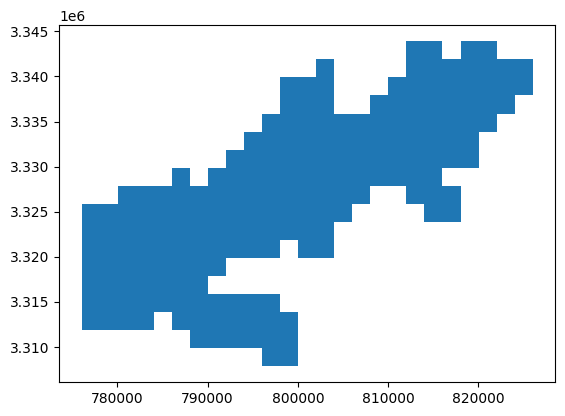

In [12]:
boxesDf.plot()


In [13]:
wgsToUTM = pyproj.transformer.Transformer.from_crs(crs_from=pyproj.CRS.from_string('WGS84'), crs_to=neighborhoodDf.crs)
meridianReg = re.compile(r'PARAMETER\["central_meridian",\-([0-9]{2})\]')


def processLas(las, boxBounds):
    lp(f"Processing for box {boxBounds}")
        
    central_meridian = int(meridianReg.findall(las.header.vlrs[0].string)[0]) * -1
        
    groundMask = np.isin(las.classification, [2,9])
    inBoundsMaskX = np.logical_and(las.X >= (boxBounds[0]*1000), (las.X <= (boxBounds[2]*1000)))
    inBoundsMaskY = np.logical_and(las.Y >= (boxBounds[1]*1000), (las.Y <= (boxBounds[3]*1000)))
    goodPointMask = np.logical_and(groundMask,inBoundsMaskX,inBoundsMaskY)
    #lp(f"{np.count_nonzero( goodPointMask )}, {np.count_nonzero( groundMask )}, {np.count_nonzero( inBoundsMaskX )} ,{np.count_nonzero( inBoundsMaskY )} in {fileName}")
    
    
    x = las.X[goodPointMask]/1000.0 #- bounds[0]
    y = (las.Y[goodPointMask]/1000.0 + wgsToUTM.transform(30,central_meridian)[1]) #- bounds[1]
 
    return (int(las.Z[goodPointMask].sum()), np.count_nonzero(las.classification[goodPointMask] == 9) , np.count_nonzero(goodPointMask))


In [14]:
processLas(laspy.read('datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0776n3318.laz'), boxesDf.iloc[0]['geometry'].bounds)

[2025-03-25 09:16:12.689111] Processing for box (776039.0, 3311888.0, 778039.0, 3313888.0)


(454712274, 405, 2709440)

In [15]:
outPath = f"{os.curdir}{os.sep}output{os.sep}"
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [16]:
lasPaths = [f"{fullDataPath}laz{os.sep}{f}" for f in os.listdir(f"{dataPath}laz")]
lasPathRdd = sc.parallelize(lasPaths)
lasDataRdd = lasPathRdd.map(laspy.read)  #.cache() #you got the ram for this hotshot

In [ ]:


seqOp = lambda x, y: (x[0]+y[0], x[1]+y[1], x[2] + y[2])
total = 0
for idx, row in boxesDf.iterrows():
    startTime = datetime.now()
    lp(f"Processing [{idx}]({total+1}/{boxesDf.shape[0]}) for bounded box {row['geometry'].bounds}")
    
    outputRdd = lasDataRdd.map(lambda x: processLas(x, row['geometry'].bounds))
    output = outputRdd.aggregate((0,0,0), seqOp, seqOp)

    boxesDf.loc[idx, 'AltitudeTotal'] = output[0]
    boxesDf.loc[idx, 'WaterTotal'] = output[1]
    boxesDf.loc[idx, 'Total'] = output[2]

    total += 1
    
    lp(f"({total}/{boxesDf.shape[0]}) Output {output} for bounded box[{idx}] {row['geometry'].bounds}  done in {datetime.now() - startTime}")
    
    
    
    

[2025-03-25 09:16:13.372290] Processing [2](1/194) for bounded box (776039.0, 3311888.0, 778039.0, 3313888.0)


[Stage 0:>                                                          (0 + 4) / 4]

In [ ]:
boxesDf.to_pickle(f"{outPath}AggregateLidarData_{resolution}m.pickle")


In [ ]:
with open(f"{outPath}FinishTime_{resolution}m.txt", 'w') as f:
    f.write(f"Finished shape {boxesDf.shape}  stop time {datetime.now()}")

In [ ]:
lp("Done!")